In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Load data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert class vectors to binary class matrices
Y_train = tf.keras.utils.to_categorical(Y_train, 10)
Y_test = tf.keras.utils.to_categorical(Y_test, 10)

# Adding bounding box data, assuming the whole image is the object
# [x_min, y_min, width, height] normalized as [0, 0, 1, 1] for simplicity
bbox_train = np.tile([0, 0, 1, 1], (50000, 1))
bbox_test = np.tile([0, 0, 1, 1], (10000, 1))

# Model Architecture
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Classification output
class_output = Dense(10, activation='softmax', name='class_output')(x)

# Bounding box output
bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)

model = Model(inputs=input_layer, outputs=[class_output, bbox_output])

# Compile the model with multiple outputs
model.compile(optimizer='adam',
              loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mean_squared_error'},
              metrics={'class_output': 'accuracy', 'bbox_output': 'mse'})

model.summary()

# Fit model
history = model.fit(X_train, {'class_output': Y_train, 'bbox_output': bbox_train},
                    validation_data=(X_test, {'class_output': Y_test, 'bbox_output': bbox_test}),
                    batch_size=64, epochs=15, verbose=1)


170498071/170498071 [==============================] - 11s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)        

In [2]:
# Evaluate the model on the test data
evaluation = model.evaluate(X_test, {'class_output': Y_test, 'bbox_output': bbox_test}, verbose=1)

# Print total loss and individual losses
print("\nTotal Loss on Test Data:", evaluation[0])
print("Classification Loss on Test Data:", evaluation[1])
print("Bounding Box Loss on Test Data:", evaluation[2])
print("Classification Accuracy on Test Data:", evaluation[3]*100, "%")
print("Bounding Box MSE on Test Data:", evaluation[4])


313/313 [==============================] - 9s 30ms/step - loss: 0.7698 - class_output_loss: 0.7698 - bbox_output_loss: 6.7483e-07 - class_output_accuracy: 0.7530 - bbox_output_mse: 6.7483e-07

Total Loss on Test Data: 0.7698389291763306
Classification Loss on Test Data: 0.769838273525238
Bounding Box Loss on Test Data: 6.748326200067822e-07
Classification Accuracy on Test Data: 75.3000020980835 %
Bounding Box MSE on Test Data: 6.748326200067822e-07


In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


1/1 [==============================] - 0s 57ms/step


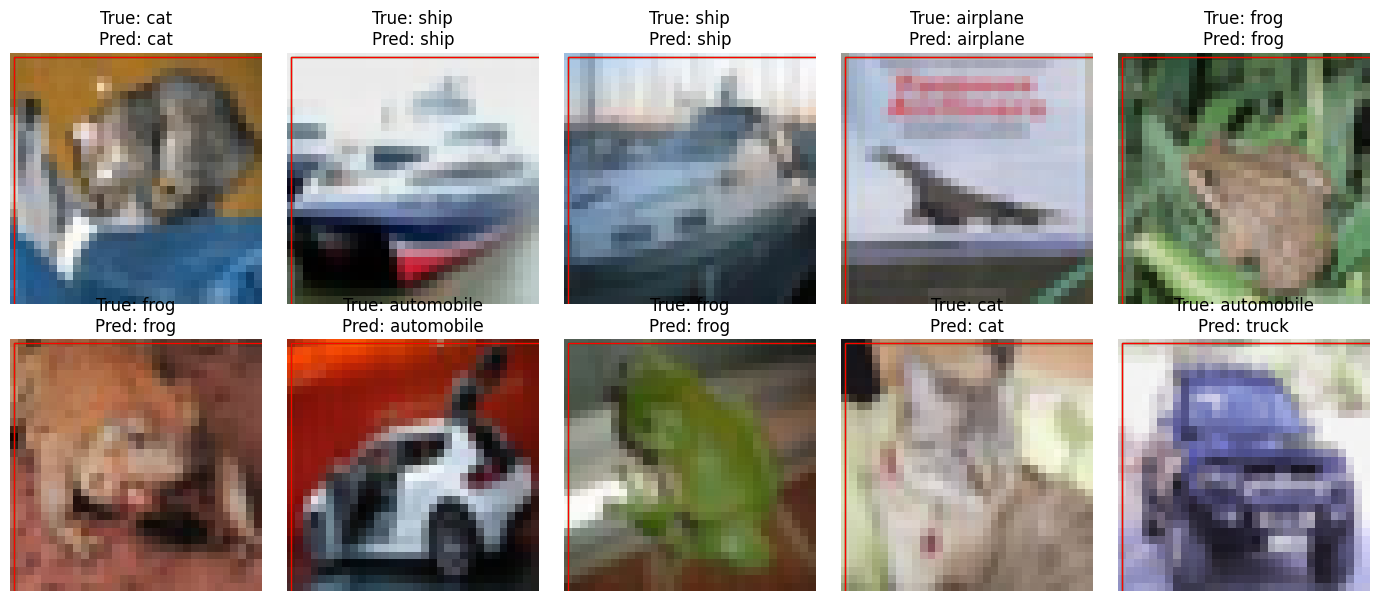

In [8]:
import matplotlib.patches as patches

def plot_predictions(images, bbox_true, bbox_pred, class_true, class_pred, class_labels):
    fig, axs = plt.subplots(2, 5, figsize=(14, 6))
    axs = axs.flatten()

    for img, bbt, bbp, ct, cp, ax in zip(images, bbox_true, bbox_pred, class_true, class_pred, axs):
        ax.imshow(img)
        # True Bounding Box in Green
        rect_true = patches.Rectangle((bbt[0]*32, bbt[1]*32), bbt[2]*32, bbt[3]*32, linewidth=1, edgecolor='g', facecolor='none')
        # Predicted Bounding Box in Red
        rect_pred = patches.Rectangle((bbp[0]*32, bbp[1]*32), bbp[2]*32, bbp[3]*32, linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect_true)
        ax.add_patch(rect_pred)
        ax.set_title(f"True: {class_labels[ct.argmax()]}\nPred: {class_labels[cp.argmax()]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Make predictions
predictions = model.predict(X_test[:10])
predicted_classes = predictions[0]
predicted_bboxes = predictions[1]

# Plotting predictions
plot_predictions(X_test[:10], bbox_test[:10], predicted_bboxes, Y_test[:10], predicted_classes, class_names)


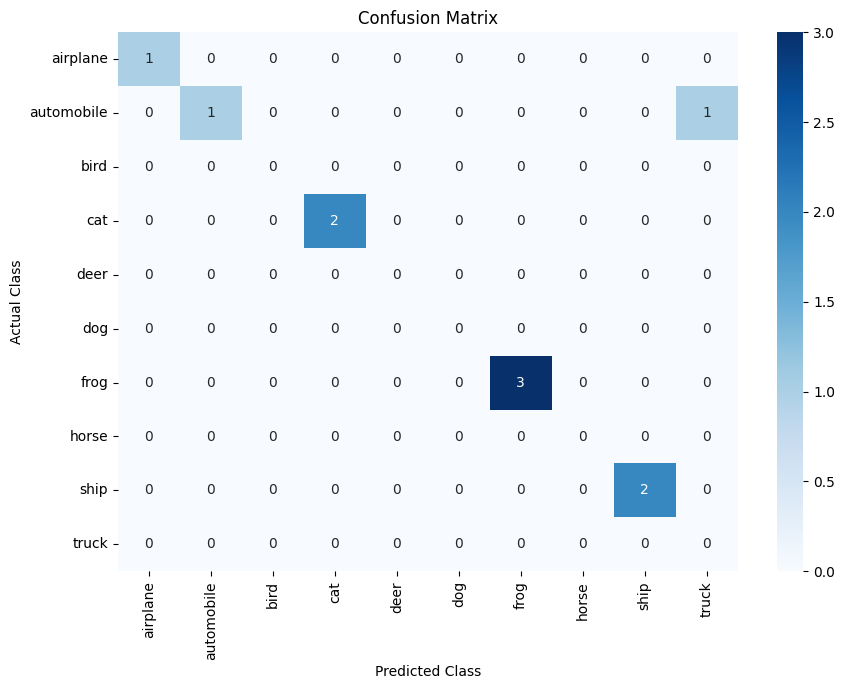

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


predicted_labels = np.argmax(predicted_classes, axis=1)
true_labels = np.argmax(Y_test[:10], axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(10))

# Plotting using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()
